In [37]:
!pip install ultralytics

In [38]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2
import glob
import shutil
import random
from tqdm import tqdm


from ultralytics import YOLO
from pathlib import Path

In [39]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/datasets/thethreemusketeers"
image_dir = os.path.join(dataset_path, "images", "train")
label_dir = os.path.join(dataset_path, "labels", "train")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Check if TensorFlow can access the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU available.")


No GPU available.


In [41]:
# def convert_images_to_jpg(image_dir):
#     image_paths = glob.glob(os.path.join(image_dir, "**/*"), recursive=True)

#     for img_path in image_paths:
#         ext = os.path.splitext(img_path)[-1].lower()
#         if ext not in [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]:
#             continue

#         try:
#             with Image.open(img_path) as img:
#                 rgb_img = img.convert("RGB")  # Ensure compatibility

#                 # Build new path with lowercase .jpg extension
#                 base = os.path.splitext(img_path)[0]
#                 new_path = base + ".jpg"

#                 if img_path != new_path:
#                     rgb_img.save(new_path, "JPEG")
#                     os.remove(img_path)  # Delete the original file

#         except Exception as e:
#             print(f"❌ Failed to convert {img_path}: {e}")

#     print("✅ All images converted to consistent `.jpg` format.")

# # Run it on your dataset
# convert_images_to_jpg(image_dir)


In [42]:
# def split_dataset(image_dir, label_dir, output_dir, split_ratio=0.8):
#     # Make new train/val folders for images and labels
#     for folder in ['train', 'val']:
#         os.makedirs(os.path.join(output_dir, 'images', folder), exist_ok=True)
#         os.makedirs(os.path.join(output_dir, 'labels', folder), exist_ok=True)

#     # Get all image files
#     image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
#     random.shuffle(image_files)

#     split_index = int(len(image_files) * split_ratio)
#     train_files = image_files[:split_index]
#     val_files = image_files[split_index:]

#     def move_files(files, subset):
#         for img_file in files:
#             # Copy image
#             src_img = os.path.join(image_dir, img_file)
#             dst_img = os.path.join(output_dir, 'images', subset, img_file)
#             shutil.copy(src_img, dst_img)

#             # Copy label with same filename (but .txt)
#             base = os.path.splitext(img_file)[0]
#             label_file = base + '.txt'
#             src_label = os.path.join(label_dir, label_file)
#             dst_label = os.path.join(output_dir, 'labels', subset, label_file)

#             if os.path.exists(src_label):
#                 shutil.copy(src_label, dst_label)
#             else:
#                 print(f"⚠️ Missing label for {img_file}")

#     move_files(train_files, 'train')
#     move_files(val_files, 'val')

#     print("✅ Dataset split completed.")

# # Example usage:
# original_image_dir = "/content/drive/MyDrive/datasets/thethreemusketeers/images"
# original_label_dir = "/content/drive/MyDrive/datasets/thethreemusketeers/labels"
# output_dir = "/content/drive/MyDrive/datasets/thethreemusketeers"  # Will create images/train, labels/train etc.

# split_dataset(original_image_dir, original_label_dir, output_dir)


In [43]:
# Class map
name_to_class_id = {
    "robbie": 0,
    "angelo": 1,
    "dhan": 2
}

# YOLO format converter
def convert_to_yolo(x, y, w, h, img_w, img_h):
    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    w /= img_w
    h /= img_h
    return x_center, y_center, w, h

# Auto-label using Haar Cascade for face detection
def generate_labels(image_dir, label_dir):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    for filename in tqdm(os.listdir(image_dir)):
        if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Failed to read {image_path}")
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        label_name = filename.split()[0].lower()
        class_id = name_to_class_id.get(label_name)

        if class_id is None:
            print(f"⚠️ Could not determine class for {filename}")
            continue

        h_img, w_img = image.shape[:2]
        label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

        # Skip non-empty label files
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                if f.read().strip():
                    continue

        with open(label_path, "w") as f:
            for (x, y, w, h) in faces:
                x_center, y_center, w_yolo, h_yolo = convert_to_yolo(x, y, w, h, w_img, h_img)
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w_yolo:.6f} {h_yolo:.6f}\n")

    print(f"✅ Done generating YOLO annotations for {image_dir}")

# Apply to both train and val sets
generate_labels("/content/drive/MyDrive/datasets/thethreemusketeers/images/train",
                "/content/drive/MyDrive/datasets/thethreemusketeers/labels/train")

generate_labels("/content/drive/MyDrive/datasets/thethreemusketeers/images/val",
                "/content/drive/MyDrive/datasets/thethreemusketeers/labels/val")


100%|██████████| 203/203 [05:26<00:00,  1.61s/it]


✅ Done generating YOLO annotations for /content/drive/MyDrive/datasets/thethreemusketeers/images/train


100%|██████████| 75/75 [03:03<00:00,  2.45s/it]

✅ Done generating YOLO annotations for /content/drive/MyDrive/datasets/thethreemusketeers/images/val


In [44]:
class_names = {
    0: "robbie",
    1: "angelo",
    2: "dhan"
}

def draw_yolo_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if not os.path.exists(label_path):
        print(f"No annotation found for {img_path}")
        return img

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x_center, y_center, box_w, box_h = map(float, parts)
            x1 = int((x_center - box_w / 2) * w)
            y1 = int((y_center - box_h / 2) * h)
            side = max(int(box_w * w), int(box_h * h))
            x2 = x1 + side
            y2 = y1 + side

            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            label = class_names.get(int(cls), f"Class {int(cls)}")
            cv2.putText(img, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    return img


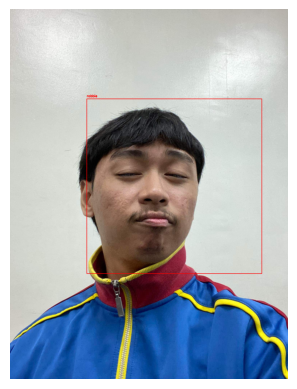

In [45]:
sample_img_path = "/content/drive/MyDrive/datasets/thethreemusketeers/images/train/robbie (1).jpg"
sample_label_path = "/content/drive/MyDrive/datasets/thethreemusketeers/labels/train/robbie (1).txt"

output_img = draw_yolo_boxes(sample_img_path, sample_label_path)
if output_img is not None:
    plt.imshow(output_img)
    plt.axis('off')
    plt.show()

In [46]:
def adjust_boxes_to_square(label_dir):
    for filename in os.listdir(label_dir):
        if not filename.endswith(".txt"):
            continue

        label_path = os.path.join(label_dir, filename)
        with open(label_path, "r") as file:
            lines = file.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            cls_id, x_center, y_center, w, h = map(float, parts)

            # Make it a perfect square using the larger dimension
            side = max(w, h)

            new_line = f"{int(cls_id)} {x_center:.6f} {y_center:.6f} {side:.6f} {side:.6f}\n"
            new_lines.append(new_line)

        # Save back to file (overwrite)
        with open(label_path, "w") as file:
            file.writelines(new_lines)

    print("✅ All YOLO label files adjusted to use square bounding boxes.")


In [48]:
label_dir_train = os.path.join(label_dir)
label_dir_val = os.path.join(label_dir)

adjust_boxes_to_square(label_dir_train)
adjust_boxes_to_square(label_dir_val)

✅ All YOLO label files adjusted to use square bounding boxes.
✅ All YOLO label files adjusted to use square bounding boxes.


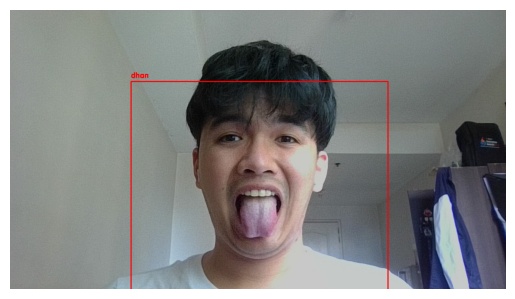

In [50]:
sample_img = os.path.join(image_dir, "dhan (7).jpg")
sample_label = os.path.join(label_dir, "dhan (7).txt")

annotated_img = draw_yolo_boxes(sample_img, sample_label)
plt.imshow(annotated_img)
plt.axis('off')
plt.show()


In [51]:
def displayImage(image_path):
  # Path to your image file in Google Drive
  image = Image.open(image_path)

  # Display the image using matplotlib
  plt.imshow(image)
  plt.axis('off')  # Hide axes for cleaner display
  plt.show()


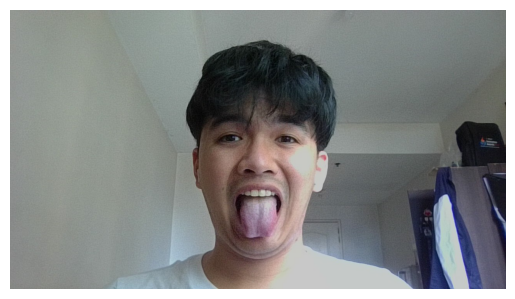

In [52]:
displayImage('/content/drive/My Drive/datasets/thethreemusketeers/images/train/dhan (7).jpg')

In [53]:
SIZE = 255
image_size = (SIZE, SIZE)

In [57]:
X = []
y_class = []
y_bbox = []
class_ids = set()

In [58]:
for filename in os.listdir(image_dir):
    if filename.endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(image_dir, filename)

        # Construct the label path based on the image filename
        label_filename = os.path.splitext(filename)[0] + ".txt"
        label_path = os.path.join(label_dir, label_filename)

        if not os.path.exists(label_path):
            print(f"⚠️ Label file not found for {image_path}, skipping...")
            continue

        # Load image
        img = cv2.imread(image_path)
        if img is None:
            print(f"⚠️ Could not read image {image_path}, skipping...")
            continue
        img = cv2.resize(img, image_size)
        img = img / 255.0

        # Load annotation
        with open(label_path, "r") as f:
            lines = f.readlines()

        # If label file is empty, delete it
        if not lines:
            print(f"🗑️ Empty label file found at {label_path}, deleting...")
            os.remove(label_path)
            continue

        # Parse annotations
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                print(f"⚠️ Invalid format in {label_path}, skipping line...")
                continue
            cls = int(parts[0])
            bbox = list(map(float, parts[1:]))

            X.append(img)
            y_class.append(cls)
            y_bbox.append(bbox)
            class_ids.add(cls)

X = np.array(X, dtype=np.float32)

🗑️ Empty label file found at /content/drive/My Drive/datasets/thethreemusketeers/labels/train/robbie (32).txt, deleting...
🗑️ Empty label file found at /content/drive/My Drive/datasets/thethreemusketeers/labels/train/robbie (35).txt, deleting...
🗑️ Empty label file found at /content/drive/My Drive/datasets/thethreemusketeers/labels/train/robbie (98).txt, deleting...
🗑️ Empty label file found at /content/drive/My Drive/datasets/thethreemusketeers/labels/train/robbie (36).txt, deleting...
🗑️ Empty label file found at /content/drive/My Drive/datasets/thethreemusketeers/labels/train/robbie (71).txt, deleting...
🗑️ Empty label file found at /content/drive/My Drive/datasets/thethreemusketeers/labels/train/dhan (52).txt, deleting...
🗑️ Empty label file found at /content/drive/My Drive/datasets/thethreemusketeers/labels/train/dhan (81).txt, deleting...
🗑️ Empty label file found at /content/drive/My Drive/datasets/thethreemusketeers/labels/train/robbie (52).txt, deleting...
🗑️ Empty label file 

In [59]:
# Setup
image_dir = "/content/drive/MyDrive/datasets/thethreemusketeers/images/train"
label_dir = "/content/drive/MyDrive/datasets/thethreemusketeers/labels/train"
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def convert_to_yolo(size, box):
    """Convert box to YOLO format: x_center, y_center, w, h (normalized)"""
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x, y, w, h = box
    x_center = (x + w / 2.0) * dw
    y_center = (y + h / 2.0) * dh
    w *= dw
    h *= dh
    return x_center, y_center, w, h

# Loop through images
for filename in os.listdir(image_dir):
    if filename.endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

        # Only handle empty files
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            continue  # already labeled

        # Load image
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        # Write label file
        with open(label_path, "w") as f:
            for (x, y, w, h) in faces:
                x_center, y_center, w_norm, h_norm = convert_to_yolo(img.shape[1::-1], (x, y, w, h))
                # Use placeholder class ID, e.g., 0 (face)
                f.write(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")


In [62]:
import os
import cv2
import numpy as np
from keras.utils import to_categorical

image_size = (255, 255)  # Your CNN input size
X, y_class, y_bbox = [], [], []
class_ids = set()

image_dir = "/content/drive/MyDrive/datasets/thethreemusketeers/images/train"
label_dir = "/content/drive/MyDrive/datasets/thethreemusketeers/labels/train"

for filename in os.listdir(image_dir):
    if filename.endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(image_dir, filename)
        label_filename = os.path.splitext(filename)[0] + ".txt"
        label_path = os.path.join(label_dir, label_filename)

        if not os.path.exists(label_path):
            print(f"Warning: Label file not found for {image_path}, skipping...")
            continue

        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image {image_path}, skipping...")
            continue
        img = cv2.resize(img, image_size)
        img = img / 255.0

        with open(label_path, "r") as f:
            lines = f.readlines()

        # Delete empty label file
        if not lines:
            print(f"🗑️ Empty label file found at {label_path}, deleting...")
            os.remove(label_path)
            continue

        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                print(f"Warning: Invalid annotation format in {label_path}, skipping line...")
                continue
            cls = int(parts[0])
            bbox = list(map(float, parts[1:]))

            X.append(img)
            y_class.append(cls)
            y_bbox.append(bbox)
            class_ids.add(cls)

# Convert to arrays
X = np.array(X, dtype=np.float32)
y_bbox = np.array(y_bbox, dtype=np.float32)

# Map class IDs to indices and one-hot encode
class_ids = sorted(list(class_ids))  # Sort to make indexing consistent
class_to_idx = {cls: idx for idx, cls in enumerate(class_ids)}

y_class = [class_to_idx[c] for c in y_class]
y_class = to_categorical(y_class, num_classes=len(class_ids))

print("Data loaded:")
print(f"X shape: {X.shape}")
print(f"y_class shape: {y_class.shape}")
print(f"y_bbox shape: {y_bbox.shape}")


🗑️ Empty label file found at /content/drive/MyDrive/datasets/thethreemusketeers/labels/train/robbie (32).txt, deleting...
🗑️ Empty label file found at /content/drive/MyDrive/datasets/thethreemusketeers/labels/train/robbie (35).txt, deleting...
🗑️ Empty label file found at /content/drive/MyDrive/datasets/thethreemusketeers/labels/train/robbie (98).txt, deleting...
🗑️ Empty label file found at /content/drive/MyDrive/datasets/thethreemusketeers/labels/train/robbie (36).txt, deleting...
🗑️ Empty label file found at /content/drive/MyDrive/datasets/thethreemusketeers/labels/train/robbie (71).txt, deleting...
🗑️ Empty label file found at /content/drive/MyDrive/datasets/thethreemusketeers/labels/train/dhan (52).txt, deleting...
🗑️ Empty label file found at /content/drive/MyDrive/datasets/thethreemusketeers/labels/train/dhan (81).txt, deleting...
🗑️ Empty label file found at /content/drive/MyDrive/datasets/thethreemusketeers/labels/train/robbie (52).txt, deleting...
🗑️ Empty label file found at

In [67]:
num_classes = len(class_ids)

In [68]:
X_train, X_test, y_cls_train, y_cls_test, y_bbox_train, y_bbox_test = train_test_split(X, y_class, y_bbox, test_size=0.2, random_state=42)

In [69]:
input_layer = layers.Input(shape=(SIZE, SIZE, 3))

x = layers.Conv2D(32, (3,3), activation='relu')(input_layer)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Output 1: class probabilities
class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)

# Output 2: bounding box (x_center, y_center, width, height)
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

model = models.Model(inputs=input_layer, outputs=[class_output, bbox_output])
model.compile(
    optimizer='adam',
    loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
    metrics={'class_output': 'accuracy'}
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 255, 255,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 253, 253,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 126, 126,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 124, 124,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 62, 62,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 246016)    │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │ 31,490,176 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 3)         │        387 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │        516 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,510,471 (120.20 MB)

 Trainable params: 31,510,471 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
history = model.fit(
    X_train,
    {'class_output': y_cls_train, 'bbox_output': y_bbox_train},
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - bbox_output_loss: 0.1689 - class_output_accuracy: 0.4541 - class_output_loss: 5.8316 - loss: 6.0699 - val_bbox_output_loss: 0.0745 - val_class_output_accuracy: 0.8519 - val_class_output_loss: 0.5564 - val_loss: 0.6309
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - bbox_output_loss: 0.0571 - class_output_accuracy: 0.9412 - class_output_loss: 0.1801 - loss: 0.2389 - val_bbox_output_loss: 0.0536 - val_class_output_accuracy: 0.9630 - val_class_output_loss: 0.0594 - val_loss: 0.1131
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - bbox_output_loss: 0.0486 - class_output_accuracy: 0.9906 - class_output_loss: 0.0397 - loss: 0.0884 - val_bbox_output_loss: 0.0463 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0317 - val_loss: 0.0780
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - bbox_output_loss: 0.0308 - class_output_accuracy: 1.0000 - class_output_loss: 0.0116 - loss: 0.0426 - val_bbox_output_loss: 0.0412 - val_class_out

In [71]:
model.evaluate(X_test, {'class_output': y_cls_test, 'bbox_output': y_bbox_test})

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 772ms/step - bbox_output_loss: 0.0326 - class_output_accuracy: 1.0000 - class_output_loss: 0.0012 - loss: 0.0354


[0.035215239971876144, 0.0013488222612068057, 0.030584895983338356, 1.0]

In [72]:
# Predict on the test set
y_pred = model.predict(X_test)

# Separate class and bounding box predictions
y_cls_pred = y_pred[0]  # The class prediction (probabilities)
y_bbox_pred = y_pred[1]  # The bounding box prediction (x_center, y_center, width, height)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 731ms/step


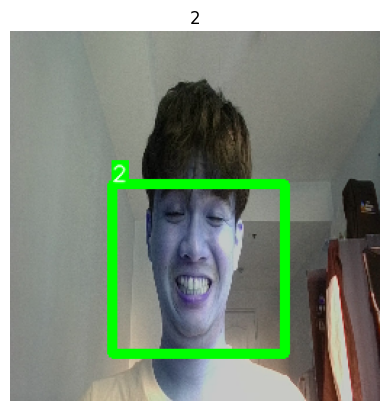

In [73]:

index = 20
img = X_test[20]

# Rescale the bounding box predictions (back to original size)
img_height, img_width, _ = img.shape
predicted_bbox = y_bbox_pred[index]

# Convert normalized bbox to pixel coordinates (0 to img_width / img_height)
x_center = predicted_bbox[0] * img_width
y_center = predicted_bbox[1] * img_height
width = predicted_bbox[2] * img_width
height = predicted_bbox[3] * img_height

# Get the top-left and bottom-right corners of the bounding box
x1 = int(x_center - width / 2)
y1 = int(y_center - height / 2)
x2 = int(x_center + width / 2)
y2 = int(y_center + height / 2)

# Show the predicted class
predicted_class = np.argmax(y_cls_pred, axis=1)
predicted_class_name = class_ids[predicted_class[index]]

img = cv2.resize(img, image_size)
img_display = (img * 255).astype(np.uint8).copy()

color = (0, 255, 0)  # Green box
thickness = 5

# Draw rectangle
cv2.rectangle(img_display, (x1, y1), (x2, y2), color, thickness)

# Choose font
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_thickness = 1

# Get text size to draw background
(text_width, text_height), _ = cv2.getTextSize(str(predicted_class_name), font, font_scale, font_thickness)

# Draw filled rectangle behind text
cv2.rectangle(img_display, (x1, y1 - text_height - 4), (x1 + text_width, y1), color, -1)

# Draw text (white text on top of the box)
cv2.putText(img_display, str(predicted_class_name), (x1, y1 - 2), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

plt.imshow(img_display)
plt.axis("off")
plt.title(predicted_class_name)
plt.show()

In [74]:
y_pred = model.predict(X_test)

# Separate the predictions
y_cls_pred = y_pred[0]  # Class probabilities
y_bbox_pred = y_pred[1]  # Bounding box predictions

# Find the predicted class for each sample
predicted_classes = np.argmax(y_cls_pred, axis=1)

# Compare with true class labels (just for class prediction)
true_classes = np.argmax(y_cls_test, axis=1)

# Calculate accuracy (for class prediction)
class_accuracy = np.mean(predicted_classes == true_classes)
print(f"Class prediction accuracy: {class_accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step
Class prediction accuracy: 1.00


In [75]:
# model = YOLO("runs/detect/train3/weights/best.pt")
# results = model.predict(source=sample_img, conf=0.5)
# results[0].show()

In [76]:
model.save('model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp0iohtddr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  List[TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)]
Captures:
  137213860548816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137213860552080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137213860550544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137213860553232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137213860552272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137213860554192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137213860554960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137213860555920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137213860553616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137213860555152: 